# MCMC Sampling of Normalizing Flow


In this notebook, we aim to sample the learned field using MCMC.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.distributions as tdist
import imageio
import matplotlib.pyplot as plt

from pyro.infer import MCMC, NUTS
from torch.distributions import constraints
from pyro.distributions import TorchDistribution


from src.model import InvariantFlowModel  # Assuming your model's class is named this and imported properly
from importlib.machinery import SourceFileLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Load model
p = SourceFileLoader('cf', 'config.py').load_module()
model = InvariantFlowModel(image_shape=p.imShape, n_layers=p.n_layers, n_kernel_knots=p.n_kernel_knots, n_nonlinearity_knots=p.n_nonlinearity_knots,learn_top=p.y_learn_top).to(device)
model.load_state_dict(torch.load('saves/20250126_16_15-model.pt'))  # Update the path to your model
model.eval() 


def potential_fn(params):
    kappa = params["x"]
    _, log_p_x = model(x=kappa[None,None], reverse=False)
    return -log_p_x.sum()  # If log_p_x has shape [batch], make sure to reduce to scalar

nuts_kernel = NUTS( potential_fn=potential_fn,
                    adapt_step_size=True,
                    adapt_mass_matrix=False,
                    full_mass=False,
                    use_multinomial_sampling=True,
                    transforms=None,
                    max_plate_nesting=None,
                    jit_compile=True,
                    jit_options=None,
                    target_accept_prob=0.8,
                    max_tree_depth=8)

# Set up MCMC
mcmc = MCMC(nuts_kernel,
            num_samples=100,
            warmup_steps=100,
            initial_params={"x": torch.zeros((p.imShape[1], p.imShape[2])).to(device)})

mcmc.run()
samples = mcmc.get_samples()["x"]
mcmc.summary()


/var/folders/qs/5xxmsq8962z19qb_qq2h56q00000gn/T/ipykernel_2859/4014665218.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saves/202501

KeyboardInterrupt: 

In [8]:
import io

In [44]:

# You can also just set some manual range, like vmin=-0.5, vmax=0.5, depending on your data.
images = []  # will hold each frame as an image (numpy array)
num_samples = samples.shape[0]

samples_x, _ = model(z=samples[:,None], reverse=True)
samples_x = samples_x[:,0]

vmin = float(samples_x[-1].min())  # e.g. -1.0
vmax = float(samples_x[-1].max())  # e.g.  1.0

for i in range(num_samples):
    fig, ax = plt.subplots()

    sample_2d = samples_x[i] 
    sample_2d = sample_2d.detach().cpu().numpy()

    im = ax.imshow(sample_2d, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Sample {i}")
    ax.axis("off")

    # Save figure to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)

    # Read the buffer back as an image
    img = imageio.v2.imread(buf)
    images.append(img)

# Save all frames as a GIF
imageio.mimsave('mcmc_samples_level3_nomassmatrix.gif', images, fps=5)


Warmup:   9%|▉         | 18/200 [04:59, 16.66s/it, step size=9.18e-04, acc. prob=0.668]


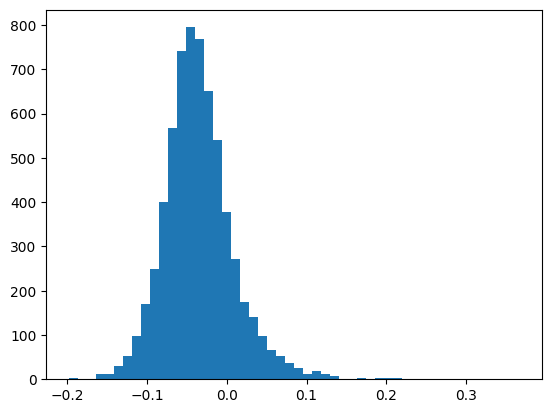

In [45]:
plt.hist(samples_x.flatten().detach().cpu().numpy(), bins=50);